Complex Laplacian and its eigenmodes are parameterized by $\alpha$ and $k$.
---

Theory and math behind the eigenmodes:

We are going to see how these eigenmodes behave in their parameter space:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, runforward

In [118]:
# Some house keeping:
data_dir = '../data'

# Define frequency range of interest
fmin = 2  # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin, fmax, 40)

# Load Pablo's Yeo 2017 canonical network maps
fc_dk = np.load(
    "../data/com_dk.npy",
    allow_pickle = True
).item()
fc_dk_normalized = pd.read_csv(
    "../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")

# Define variables for analysis:
alpha_vec = np.linspace(0.5,4.5,17) #np.linspace(0.5,5,10) # coupling strength values we are going to explore
k_vec     = np.linspace(0,100,11) # wave numbers we are going to explore
num_fc    = 7 # 7 canonical networks
num_emode = 86 # number of eigenmodes, we are using 86 region DK atlas

default_k = 20 # default wave number
default_alpha = 0.1 # default alpha

fc_names = [
    "Visual",
    "Limbic",
    "Default",
    "Somato \n motor",
    "Fronto \n parietal",
    "Ventral \n Attention",
    "Dorsal \n Attention",
]

# turbo color map
turbo = functions.create_turbo_colormap()

#### Explore varying coupling strength while keeping wave number default first

In [93]:
alpha_brain = Brain.Brain()
alpha_brain.add_connectome(data_dir)
alpha_brain.reorder_connectome(alpha_brain.connectome, alpha_brain.distance_matrix)
alpha_brain.bi_symmetric_c()
alpha_brain.reduce_extreme_dir()

## Compute correlation values:
alpha_corr = np.zeros((num_emode, num_fc, len(alpha_vec)))
for alpha in np.arange(0, len(alpha_vec)):
    alpha_brain.decompose_complex_laplacian(
        alpha = alpha_vec[alpha],
        k = default_k
    )
    alpha_corr[:,:,alpha] = eigenmode.get_correlation_df(alpha_brain.norm_eigenmodes, fc_dk_normalized, method = 'spearman')

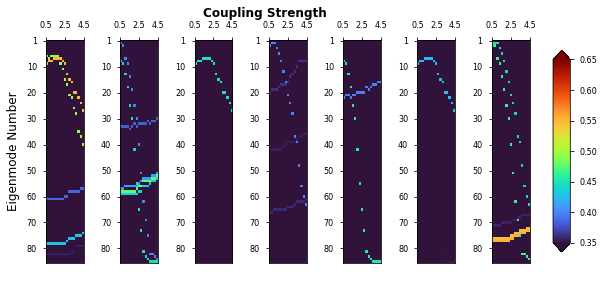

In [113]:
dynamic_range = [0.35, 0.65]
alpha_labels  = np.linspace(0.5,4.5,3)
n_ticks = 3

with plt.style.context('seaborn-paper'):
    alpha_corr_fig, alpha_ax = plt.subplots(1,7, figsize = (8.0,4.0))
    for i, ax in enumerate(alpha_corr_fig.axes):
        im = ax.imshow(alpha_corr[:,i,:], vmin = 0, vmax = 1, cmap = turbo, aspect = 'auto')
        ax.xaxis.set_major_locator(plt.LinearLocator(numticks = n_ticks)) #LinearLocator(numticks = n_ticks)
        ax.set_yticklabels([0, 1, 10, 20, 30, 40, 50, 60, 70, 80])
        ax.xaxis.tick_top()
        ax.set_xticklabels(alpha_labels, linespacing = 0.2)
        im.set_clim(dynamic_range)
        
    plt.suptitle('Coupling Strength', fontsize = 12, fontweight = 'bold', y = 1)

    cbar_ax = alpha_corr_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = alpha_corr_fig.colorbar(im, cax = cbar_ax, extend = 'both')
    alpha_corr_fig.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel('Eigenmode Number', fontsize = 12)
    
    plt.tight_layout()

#### Set to default $\alpha$ and explore wave number now:

In [116]:
k_brain = Brain.Brain()
k_brain.add_connectome(data_dir)
k_brain.reorder_connectome(k_brain.connectome, k_brain.distance_matrix)
k_brain.bi_symmetric_c()
k_brain.reduce_extreme_dir()

# preallocate empty correlation df
k_corr = np.zeros((num_emode, num_fc, len(k_vec)))

## Compute correlations
for k in np.arange(0, len(k_vec)):
    k_brain.decompose_complex_laplacian(
        alpha = 0.5,
        k = k_vec[k],
        num_ev = 86
    )
    k_corr[:,:,k] = eigenmode.get_correlation_df(k_brain.norm_eigenmodes, fc_dk_normalized, method = 'spearman')

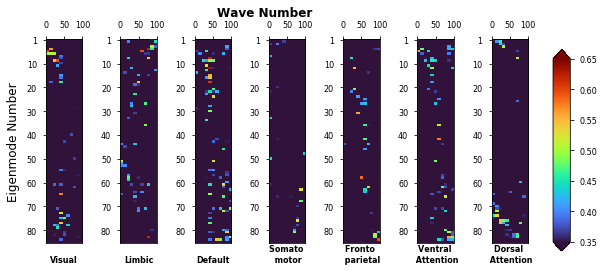

In [122]:
n_ticks = 3
k_labels =[0, 50, 100]

with plt.style.context('seaborn-paper'):
    k_corr_fig, k_ax = plt.subplots(1,7, figsize = (8.0,4.0))
    for i, ax in enumerate(k_corr_fig.axes):
        im = ax.imshow(k_corr[:,i,:], vmin = 0, vmax = 1, cmap = turbo, aspect = 'auto')
        ax.xaxis.set_major_locator(plt.LinearLocator(numticks = n_ticks)) #LinearLocator(numticks = n_ticks)
        ax.set_yticklabels([0, 1, 10, 20, 30, 40, 50, 60, 70, 80])
        ax.xaxis.tick_top()
        ax.set_xticklabels(k_labels)
        im.set_clim(dynamic_range)
        ax.set_title(fc_names[i], y = -0.12, fontsize = 8, weight = 'bold')
        
    plt.suptitle('Wave Number', fontsize = 12, fontweight = 'bold', y = 1)
    
    cbar_ax = k_corr_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = k_corr_fig.colorbar(im, cax = cbar_ax, extend = 'both')
    k_corr_fig.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel('Eigenmode Number', fontsize = 12)
    
    plt.tight_layout()